In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [3]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.svm import SVC

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


In [4]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/Epileptic Seizure Recognition.csv')

In [6]:
raw_data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [7]:
raw_data.tail()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3
11499,X16.V1.210,29,41,57,72,74,62,54,43,31,...,-59,-25,-4,2,5,4,-2,2,20,4


In [8]:
data = raw_data.values
data = data[0:11500, 1:180]
#data[:, 178] = data[:, 178].astype(int)
data.shape

(11500, 179)

In [9]:
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


In [10]:
df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

In [11]:
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.7), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)
label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(3220,) (3220, 178, 1)
(690,) (690, 178, 1)
(690,) (690, 178, 1)


In [12]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)


In [13]:
# Defining CNN network
def network_CNN(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
    batch_normalization = BatchNormalization()(conv1d_1)
    max_pooling1d = layers.MaxPooling1D( 2, padding='same')(batch_normalization)
    conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
    batch_normalization_1 = BatchNormalization()(conv1d_2)
    max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)
    flatten = Flatten()(max_pooling1d_1)
    dense = Dense(32)(flatten)
    dense_1 = Dense(16)(dense)
    main_output = Dense(2)(dense_1)
    model1 = Model(inputs= inputs_cnn, outputs=main_output)
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model1)

In [14]:
model1 = network_CNN(data_train,label_train)
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 32)           224       
                                                                 
 batch_normalization (BatchN  (None, 173, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 87, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 85, 64)           256   

In [15]:
save_path = '/tmp/checkpoint_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model1.fit(data_train, label_train,epochs=150, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/150
101/101 [==============================] - 16s 12ms/step - loss: 0.9018 - accuracy: 0.8171 - val_loss: 0.6711 - val_accuracy: 0.6928
Epoch 2/150
101/101 [==============================] - 1s 7ms/step - loss: 0.6598 - accuracy: 0.8453 - val_loss: 0.6402 - val_accuracy: 0.8101
Epoch 3/150
101/101 [==============================] - 1s 7ms/step - loss: 0.6609 - accuracy: 0.8509 - val_loss: 0.6489 - val_accuracy: 0.8333
Epoch 4/150
101/101 [==============================] - 1s 7ms/step - loss: 0.6622 - accuracy: 0.8522 - val_loss: 0.6731 - val_accuracy: 0.8594
Epoch 5/150
101/101 [==============================] - 1s 9ms/step - loss: 0.6753 - accuracy: 0.8811 - val_loss: 0.6771 - val_accuracy: 0.8739
Epoch 6/150
101/101 [==============================] - 1s 8ms/step - loss: 0.6736 - accuracy: 0.8839 - val_loss: 0.6710 - val_accuracy: 0.8754
Epoch 7/150
101/101 [==============================] - 1s 7ms/step - loss: 0.6727 - accuracy: 0.8758 - val_loss: 0.6710 - val_accuracy: 0.87

Accuracy: 88.55%


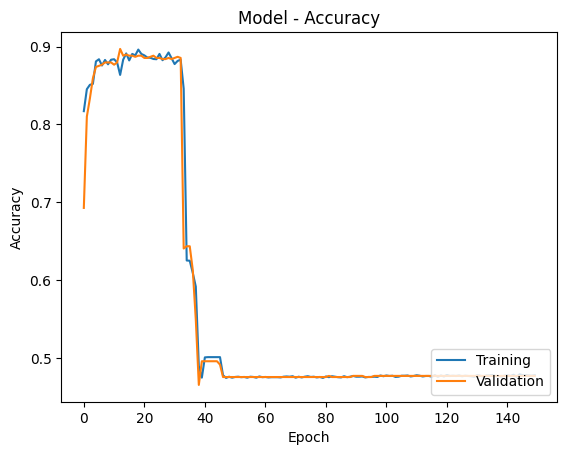

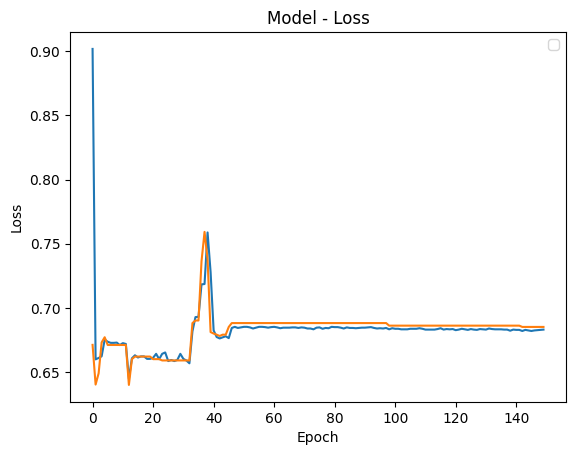

22/22 [==============================] - 0s 2ms/step


In [16]:
model1.load_weights(save_path)
evaluate_model(history,data_test,label_test,model1)

In [17]:
# Defining Bidirectional LSTM model
def network_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
    lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
    dropout = Dropout(0.3)(lstm)
    batch_normalization = BatchNormalization(name='batch_normalization')(dropout)
    dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
    dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
    main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

model2 = network_LSTM(data_train, label_train)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [18]:
# Training BiLSTM model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history2 = model2.fit(data_train, label_train,epochs=150, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/150
101/101 [==============================] - 10s 28ms/step - loss: 0.2575 - accuracy: 0.9000 - val_loss: 0.1178 - val_accuracy: 0.9594
Epoch 2/150
101/101 [==============================] - 2s 18ms/step - loss: 0.1615 - accuracy: 0.9478 - val_loss: 0.1233 - val_accuracy: 0.9565
Epoch 3/150
101/101 [==============================] - 2s 20ms/step - loss: 0.1474 - accuracy: 0.9478 - val_loss: 0.1403 - val_accuracy: 0.9594
Epoch 4/150
101/101 [==============================] - 2s 21ms/step - loss: 0.1421 - accuracy: 0.9484 - val_loss: 0.0830 - val_accuracy: 0.9710
Epoch 5/150
101/101 [==============================] - 3s 25ms/step - loss: 0.1339 - accuracy: 0.9512 - val_loss: 0.1186 - val_accuracy: 0.9507
Epoch 6/150
101/101 [==============================] - 3s 25ms/step - loss: 0.1239 - accuracy: 0.9578 - val_loss: 0.0581 - val_accuracy: 0.9783
Epoch 7/150
101/101 [==============================] - 2s 18ms/step - loss: 0.1279 - accuracy: 0.9543 - val_loss: 0.0798 - val_accuracy

Accuracy: 98.55%


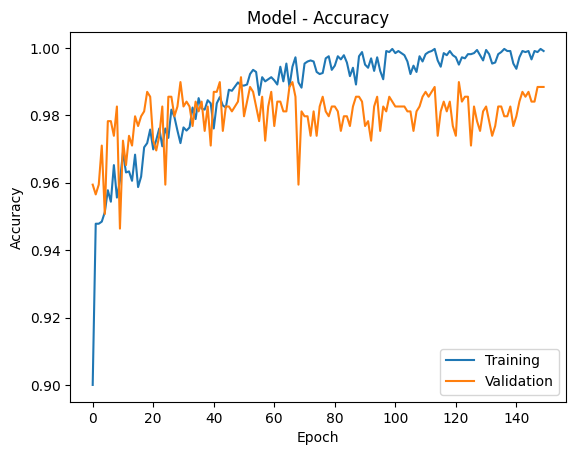

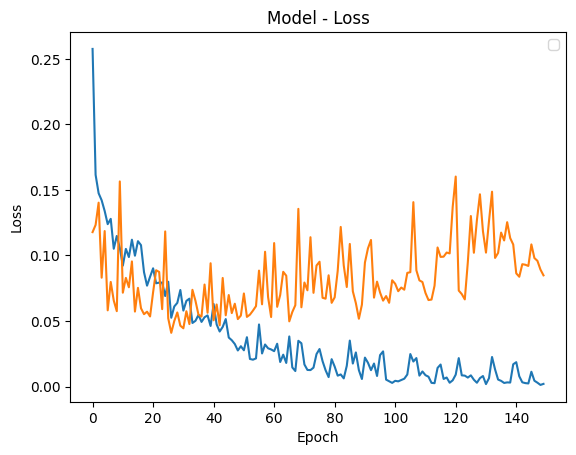

22/22 [==============================] - 1s 9ms/step


In [19]:
evaluate_model(history2,data_test,label_test,model2)

Accuracy: 98.84%


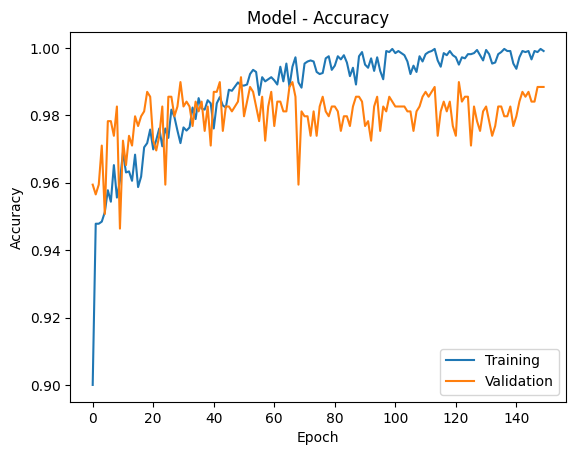

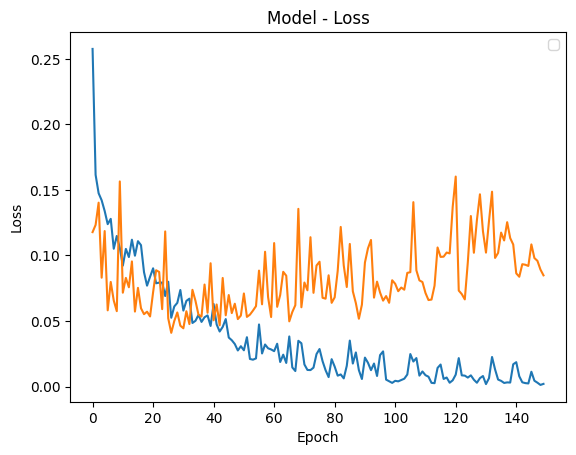

22/22 [==============================] - 0s 7ms/step


In [20]:
model2.load_weights(save_path)
evaluate_model(history2,data_test,label_test,model2)

In [21]:
# Defining the data categories
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


In [22]:
# Concatenating 4 categories into 1 data set
df_2[:, 178] = df_2[:, 178] - 2
df_3[:, 178] = df_3[:, 178] - 3
df_4[:, 178] = df_4[:, 178] - 4
df_5[:, 178] = df_5[:, 178] - 5

D2 = np.concatenate([df_1, df_2, df_3, df_4, df_5])

In [23]:
number_of_rows = D2.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.7), replace=False)

label_train_all = D2[random_indices, -1]
data_train_all = D2[random_indices, :-1]

D2_rest = np.delete(D2, random_indices, 0)

number_of_rows = D2_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val_all = D2_rest[random_indices, -1]
data_val_all = D2_rest[random_indices, :-1]

D2_rest_rest = np.delete(D2_rest, random_indices, 0)
label_test_all = D2_rest_rest[:, -1]
data_test_all = D2_rest_rest[:, :-1]

data_train_all = np.expand_dims(data_train_all, axis=2)
data_val_all = np.expand_dims(data_val_all, axis=2)
data_test_all = np.expand_dims(data_test_all, axis=2)

print(label_train_all.shape, data_train_all.shape)
print(label_val_all.shape, data_val_all.shape)
print(label_test_all.shape, data_test_all.shape)

# Defining CNN model to be trained on epileptic vs all data
model3 = network_CNN(data_train_all,label_train_all)
print(model3.summary())

(8049,) (8049, 178, 1)
(1725,) (1725, 178, 1)
(1726,) (1726, 178, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 173, 32)           224       
                                                                 
 batch_normalization_2 (Batc  (None, 173, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 87, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 64)            6208      
                                                        

In [24]:
# Training CNN model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_3'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history3 = model3.fit(data_train_all, label_train_all,epochs=150, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/150
252/252 [==============================] - 6s 12ms/step - loss: 0.8583 - accuracy: 0.7878 - val_loss: 0.6920 - val_accuracy: 0.8313
Epoch 2/150
252/252 [==============================] - 2s 9ms/step - loss: 0.6890 - accuracy: 0.8449 - val_loss: 0.6864 - val_accuracy: 0.8412
Epoch 3/150
252/252 [==============================] - 2s 6ms/step - loss: 0.6785 - accuracy: 0.7658 - val_loss: 0.6939 - val_accuracy: 0.5362
Epoch 4/150
252/252 [==============================] - 2s 7ms/step - loss: 0.6943 - accuracy: 0.4681 - val_loss: 0.7005 - val_accuracy: 0.5188
Epoch 5/150
252/252 [==============================] - 2s 7ms/step - loss: 0.6911 - accuracy: 0.4656 - val_loss: 0.7005 - val_accuracy: 0.5014
Epoch 6/150
252/252 [==============================] - 2s 6ms/step - loss: 0.7019 - accuracy: 0.2149 - val_loss: 0.6931 - val_accuracy: 0.2255
Epoch 7/150
252/252 [==============================] - 2s 6ms/step - loss: 0.6985 - accuracy: 0.2025 - val_loss: 0.6931 - val_accuracy: 0.216

Accuracy: 19.00%


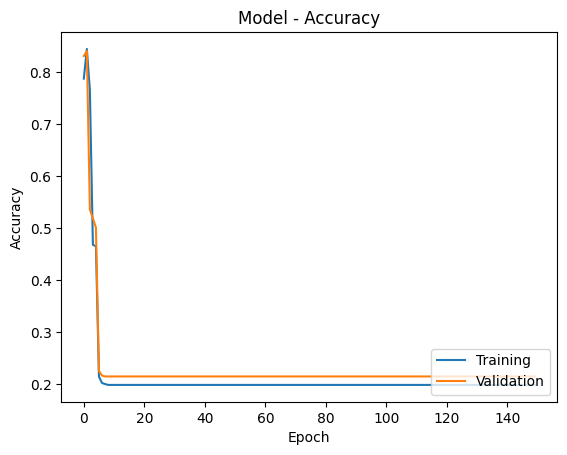

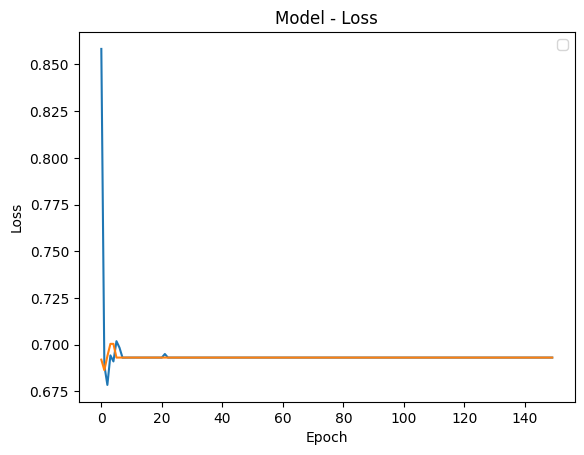

54/54 [==============================] - 0s 2ms/step


In [25]:
# Printing validation accuracy and plot accuracy and loss
evaluate_model(history3, data_test_all, label_test_all, model3)

Accuracy: 86.10%


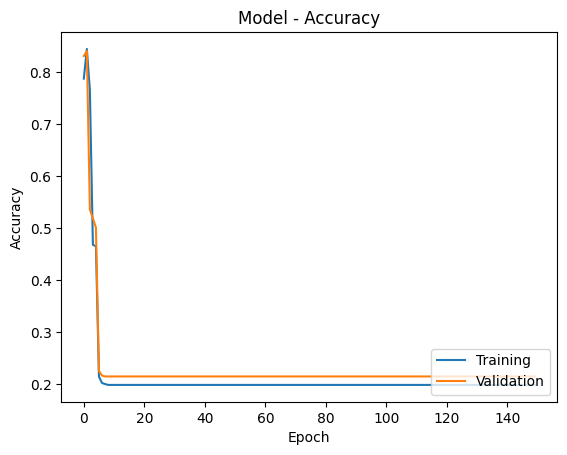

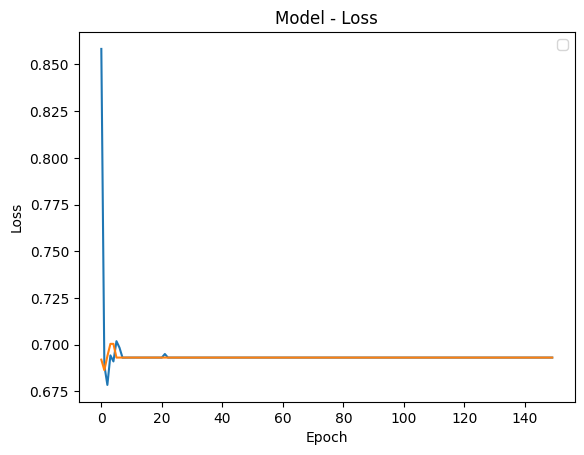

54/54 [==============================] - 0s 2ms/step


In [26]:
# Printing validation accuracy and plot accuracy and loss for the model's best version
model3.load_weights(save_path)
evaluate_model(history3, data_test_all, label_test_all, model3)

In [27]:
# Defining BiLSTM model to be trained on epileptic vs all data
model4 = network_LSTM(data_train_all,label_train_all)
print(model4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [28]:
# Training BiLSTM model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_4'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history4 = model4.fit(data_train_all, label_train_all,epochs=150, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/150
252/252 [==============================] - 12s 23ms/step - loss: 0.3087 - accuracy: 0.8836 - val_loss: 0.1839 - val_accuracy: 0.9357
Epoch 2/150
252/252 [==============================] - 6s 22ms/step - loss: 0.1843 - accuracy: 0.9361 - val_loss: 0.1263 - val_accuracy: 0.9530
Epoch 3/150
252/252 [==============================] - 5s 19ms/step - loss: 0.1597 - accuracy: 0.9441 - val_loss: 0.1305 - val_accuracy: 0.9530
Epoch 4/150
252/252 [==============================] - 5s 18ms/step - loss: 0.1446 - accuracy: 0.9478 - val_loss: 0.0982 - val_accuracy: 0.9577
Epoch 5/150
252/252 [==============================] - 6s 24ms/step - loss: 0.1400 - accuracy: 0.9489 - val_loss: 0.1069 - val_accuracy: 0.9606
Epoch 6/150
252/252 [==============================] - 5s 19ms/step - loss: 0.1314 - accuracy: 0.9544 - val_loss: 0.1251 - val_accuracy: 0.9501
Epoch 7/150
252/252 [==============================] - 5s 18ms/step - loss: 0.1171 - accuracy: 0.9583 - val_loss: 0.0853 - val_accuracy

Accuracy: 98.73%


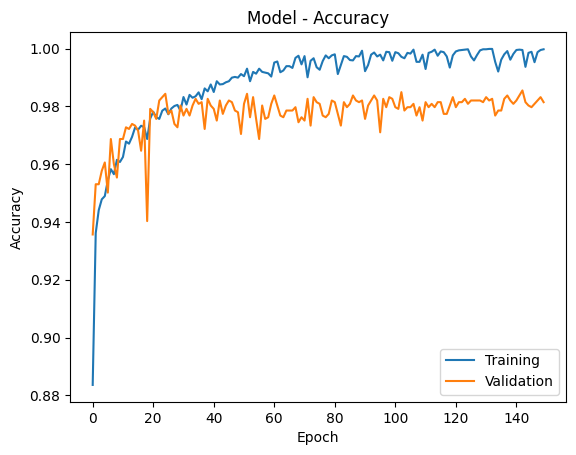

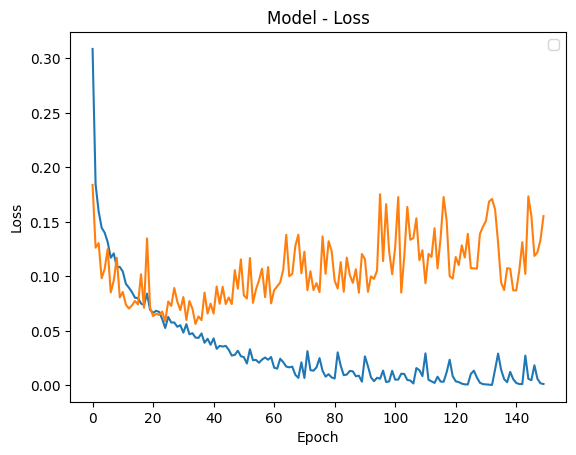

54/54 [==============================] - 1s 7ms/step


In [29]:
# Printing validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model4)

Accuracy: 98.61%


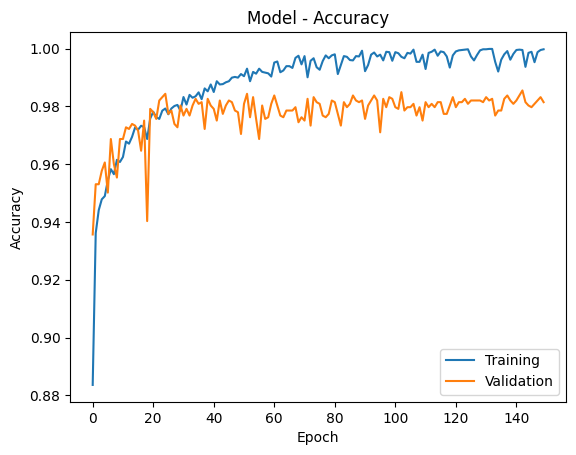

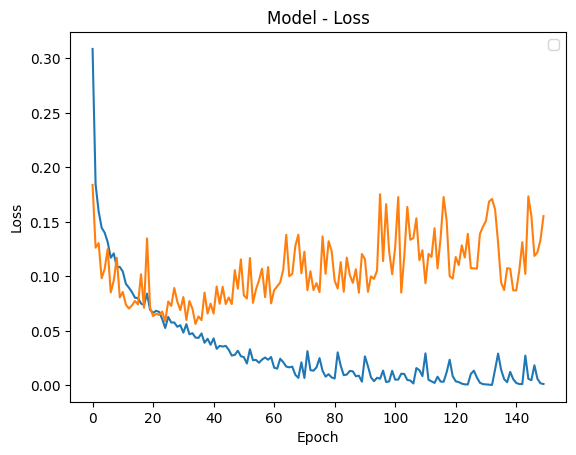

54/54 [==============================] - 0s 8ms/step


In [30]:
# Printing validation accuracy and plot accuracy and loss for the model's best version
model4.load_weights(save_path)
evaluate_model(history4, data_test_all, label_test_all, model4)

In [31]:
import tensorflow as tf
# calling the insert() function
data_test_all = np.insert(data_test_all, len(data_test_all), data_val_all, axis = 0 )
label_test_all = np.insert(label_test_all, len(label_test_all), label_val_all, axis = 0 )
X_test = np.squeeze(data_test_all)
X_train = np.squeeze(data_train_all)
y_train = np.squeeze(label_train_all)
y_train[y_train < 0] = 0
y_test = np.squeeze(label_test_all)
y_test[y_test < 0] = 0
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
predictionOfBiLSTM = []
for i in range(X_test.shape[0]):
    inputOur = X_test[i]
    row_tensor = tf.convert_to_tensor(inputOur, dtype=tf.float32)

    # Reshape the tensor to match the expected input shape of the model
    row_tensor = tf.reshape(row_tensor, (1, np.array(inputOur).reshape(-1, 1).shape[0], np.array(inputOur).reshape(-1, 1).shape[1]))
    # Perform predictions on the new data
    predictions = model4.predict(row_tensor)
    # Get the predicted class for each prediction
    predicted_classes = predictions.argmax(axis=1)
    predictionOfBiLSTM.append(int(predicted_classes))

1/1 [==============================] - 0s 30ms/step


In [34]:
accBiLSTM = round(accuracy_score(y_test, predictionOfBiLSTM) * 100, 2)
print("BiLSTM: ", accBiLSTM)
p=precision_score(y_test, predictionOfBiLSTM)
r=recall_score(y_test, predictionOfBiLSTM)
f1=f1_score(y_test, predictionOfBiLSTM)
print("Precision: ", p,"\nRecall: ", r, "\nF1 score: ", f1)

BiLSTM:  98.58
Precision:  0.9670014347202296 
Recall:  0.9628571428571429 
F1 score:  0.964924838940587
